In [5]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.stats import norm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay
from torchmetrics import Accuracy


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
    train_classification,
    evaluate_classification
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [6]:
asset_type = "all"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

# metric_key = f"{metric_key_unsmoothed}_smoothed"
metric_key = "median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [7]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

evaluation_type = "classification"

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (29837, 55), Eval: (8122, 55)


In [8]:
train_df[(train_df["area_code"] == 13101) & (train_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
15,2007,2.271493e+06,0.393871,0.983720
220,2008,2.333333e+06,0.105263,0.022257
1439,2009,1.920000e+06,-0.154741,-0.316067
4976,2010,2.037037e+06,-0.126984,-0.215148
7742,2011,1.444444e+06,-0.247685,-0.672931
7928,2012,1.455556e+06,-0.285455,-0.658649
10959,2013,2.303030e+06,0.594406,1.149448
14229,2014,2.000000e+06,0.374046,0.689789
18553,2015,2.173913e+06,-0.056064,-0.243456
19296,2016,2.645833e+06,0.322917,0.263091


In [9]:
eval_df[(eval_df["area_code"] == 13101) & (eval_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
1952,2020,3.787942e+06,0.237409,0.186068
4802,2021,4.420875e+06,0.312098,0.326362
6333,2022,4.333333e+06,0.143981,0.108697


In [10]:
idx = 6168
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, asset_type, year = row["area_code"], row["asset_type"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["asset_type"] == asset_type)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window

Target: -0.2306248194954131


,area_code,area,year,asset_type,unit_price_median_pct_chg,count_growth,yearly_price_growth,total_tax_growth,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,unit_price_median,count,total_traded_area,in_migrations,out_migrations,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,total_tax,new_dwellings,existing_dwellings,unit_price_median_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,in_migrations_log_normalized_yearly,out_migrations_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_pct_chg_normalized_yearly,count_growth_normalized_yearly,yearly_price_growth_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,taxpayer_count_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,metric_pct_chg_is_available,condo,land,log_population,weight
26148,11465,Saitama-ken Matsubushi-machi,2016,land,-0.579832,0.526316,-0.193548,0.011906,0.009611,-0.000329,-0.004869,0.0,0.009943,25000.0,29.0,9360.0,822.0,963.0,28959.0,13509.0,39117879.0,2895.690207,3128204.0,0.0,0.0,0.086104,-0.357883,-0.584025,-0.030937,-0.008587,0.045131,0.204797,0.215916,0.228748,0.036654,0.0,0.0,-1.138660,1.182141,-0.451458,0.177223,-0.439814,-0.399604,-0.187623,0.0,-0.220491,1,1,0,1,1,0.0,1.0,4.461799,2.014330
27251,11465,Saitama-ken Matsubushi-machi,2017,land,0.032258,-0.310345,0.280000,-0.011579,0.018364,0.008066,-0.003088,0.0,0.010215,32000.0,20.0,8925.0,814.0,903.0,28818.0,13647.0,39836224.0,2919.046237,3091984.0,0.0,0.0,0.303437,-0.686503,-0.641996,-0.029039,-0.046497,0.044046,0.205519,0.216689,0.228425,0.019281,0.0,0.0,-0.118894,-0.769591,0.349260,-0.656747,0.025026,-0.013090,0.046884,0.0,0.069267,1,1,0,1,1,0.0,1.0,4.459679,2.008507
32346,11465,Saitama-ken Matsubushi-machi,2018,land,-0.440000,2.750000,-0.562500,0.010963,0.023556,0.022882,-0.007205,0.0,0.000659,14000.0,75.0,61275.0,746.0,953.0,28729.0,13656.0,40774618.0,2985.839045,3125881.0,0.0,0.0,-0.372464,0.529757,1.118557,-0.074312,-0.008567,0.044243,0.201992,0.220352,0.299595,0.022443,0.0,0.0,-0.819762,5.681596,-0.283170,0.268944,0.118783,0.250355,-0.431529,0.0,-0.244216,1,1,0,1,1,0.0,1.0,4.458336,2.006549
33188,11465,Saitama-ken Matsubushi-machi,2019,land,-0.390625,-0.653333,0.392857,0.017388,0.000601,0.001188,-0.008976,0.0,-0.000586,19500.0,26.0,13210.0,718.0,974.0,28522.0,13648.0,40799139.0,2989.385917,3180234.0,0.0,0.0,-0.096994,-0.372608,-0.211274,-0.086579,0.006604,0.041902,0.199630,0.214791,0.266047,0.889149,0.0,0.0,-0.483302,-1.395733,0.387327,0.220580,-0.178137,-0.141081,-0.560869,0.0,-0.124816,1,1,0,1,1,0.0,1.0,4.455195,2.003409
36162,11465,Saitama-ken Matsubushi-machi,2020,land,0.964286,-0.307692,0.410256,0.023144,-0.007710,-0.003401,-0.006828,0.0,-0.004323,27500.0,18.0,6770.0,727.0,920.0,28266.0,13589.0,40484590.0,2979.217750,3253837.0,0.0,0.0,0.188198,-0.752586,-0.840789,-0.067808,-0.007404,0.038743,0.195908,0.208111,0.238768,0.884599,0.0,0.0,0.605526,-0.939177,0.510134,0.685876,-0.258996,-0.153084,-0.369291,0.0,-0.308654,1,1,0,1,1,0.0,1.0,4.451280,2.000261


In [18]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [19]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead,
    type=evaluation_type
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
    type=evaluation_type
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 27) (1,) [0] [1.59989883]
1 (1, 27) (1,) [2] [2.8857632]
2 (1, 27) (1,) [1] [2.64552867]
3 (1, 27) (1,) [2] [3.96037426]
0 torch.Size([5, 27]) torch.Size([1]) tensor([0.]) tensor([1.5999])
1 torch.Size([5, 27]) torch.Size([1]) tensor([2.]) tensor([2.8858])
2 torch.Size([5, 27]) torch.Size([1]) tensor([1.]) tensor([2.6455])
3 torch.Size([5, 27]) torch.Size([1]) tensor([2.]) tensor([3.9604])


In [20]:
BATCH_SIZE = 256

In [21]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
    type=evaluation_type
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
    type=evaluation_type
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Building the Transformer Model

In [22]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [23]:
n_features = len(feature_columns)
d_model = 128
d_hid = 128
nlayers = 4
nhead = 4
dropout = 0
enc_dropout = 0
target_size = 3 if evaluation_type == "classification" else 1

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
    target_size=target_size,
)
model = model.to(device)

In [24]:
model.eval()

# mse_loss_weighted = MSELossWeighted().to(device)
cross_entropy_loss = torch.nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=3).to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = cross_entropy_loss(outputs, target.squeeze(1).to(torch.long))
        accuracy.update(outputs.argmax(dim=1), target.squeeze())

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
            outputs.shape
        )
        print("Accuracy:", accuracy.compute().item())
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 27]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1]) torch.Size([256, 3])
Accuracy: 0.19140625
Loss: 1.2246971130371094


In [25]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 50

In [26]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_accuracy_scores = [], []
eval_losses, eval_accuracy_scores = [], []

In [27]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_accuracy_score = train_classification(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_accuracy_scores.append(train_accuracy_score)

    eval_loss, eval_accuracy_score = evaluate_classification(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_accuracy_scores.append(eval_accuracy_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy_score:.4f}, Eval Accuracy: {eval_accuracy_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 218.8579, Eval Loss: 210.5315
Train Accuracy: 0.5996, Eval Accuracy: 0.6274
Epoch: 1
Train Loss: 207.5754, Eval Loss: 195.1512
Train Accuracy: 0.6270, Eval Accuracy: 0.6557
Epoch: 2
Train Loss: 194.0856, Eval Loss: 177.6201
Train Accuracy: 0.6550, Eval Accuracy: 0.6899
Epoch: 3
Train Loss: 188.4486, Eval Loss: 175.7541
Train Accuracy: 0.6639, Eval Accuracy: 0.6919
Epoch: 4
Train Loss: 185.3299, Eval Loss: 175.3197
Train Accuracy: 0.6705, Eval Accuracy: 0.6905
Epoch: 5
Train Loss: 183.2493, Eval Loss: 175.4410
Train Accuracy: 0.6735, Eval Accuracy: 0.6875
Epoch: 6
Train Loss: 181.6126, Eval Loss: 175.3353
Train Accuracy: 0.6771, Eval Accuracy: 0.6883
Epoch: 7
Train Loss: 180.3407, Eval Loss: 175.0970
Train Accuracy: 0.6798, Eval Accuracy: 0.6879
Epoch: 8
Train Loss: 179.3386, Eval Loss: 174.6605
Train Accuracy: 0.6825, Eval Accuracy: 0.6897
Epoch: 9
Train Loss: 178.5256, Eval Loss: 174.0484
Train Accuracy: 0.6845, Eval Accuracy: 0.6900
Epoch: 10
Train Loss: 177.8502

KeyboardInterrupt: 

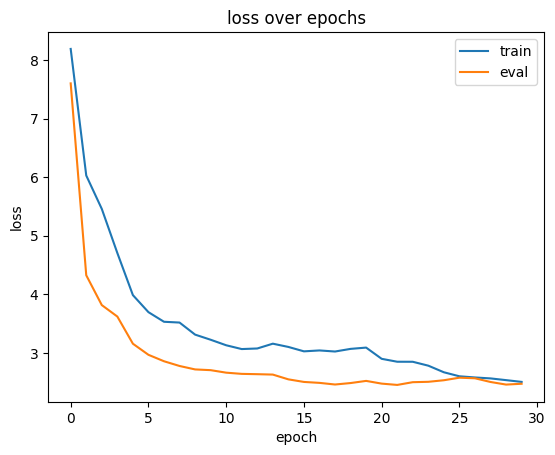

In [33]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

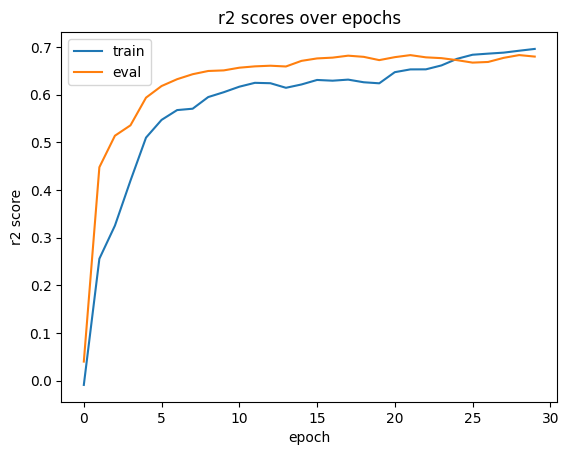

In [34]:
# Plot R2 scores
plt.plot(train_accuracy_scores, label = "train")
plt.plot(eval_accuracy_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [35]:
# smoothed model
loss, epoch_accuracy_score = evaluate_classification(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_accuracy_score:.4f}")

Eval loss: 2.4709
Eval R2: 0.6796


In [36]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [37]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
18074,2022,27221,-1.298147,-0.313324,-1.323509
17324,2022,28212,-0.249031,-0.147399,-0.663334
17318,2022,15206,-0.854303,-0.233155,-1.004535
17319,2022,47348,1.672437,0.423042,1.606304
17320,2022,21361,-1.572772,-0.572982,-2.356621
...,...,...,...,...,...
15411,2020,24203,-0.396602,-0.157997,-1.050942
15410,2020,8214,-0.022239,-0.030913,-0.309195
15409,2020,27203,0.457672,0.166667,0.844006
15408,2020,14341,-0.595804,-0.160141,-1.063457


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

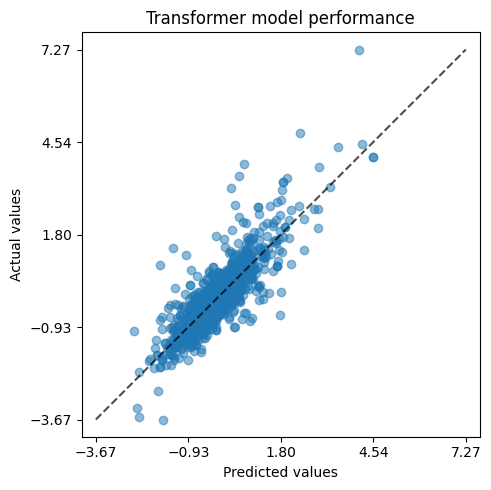

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

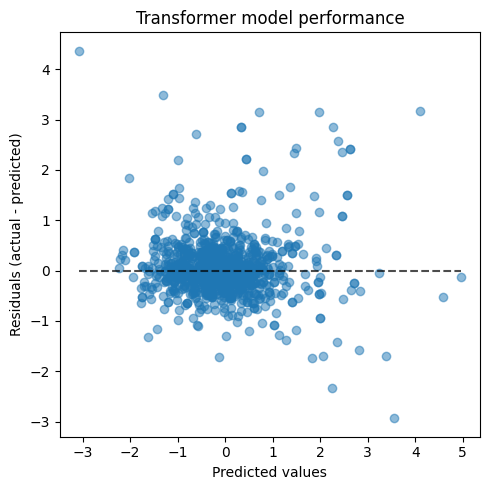

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()